### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Data
https://www.kaggle.com/competitions/spaceship-titanic

---
Task is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly. 

##### Data Dictionary
    PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
    HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
    CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
    Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
    Destination - The planet the passenger will be debarking to.
    Age - The age of the passenger.
    VIP - Whether the passenger has paid for special VIP service during the voyage.
    RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
    Name - The first and last names of the passenger.
    Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

---

In [2]:
df_train = pd.read_csv("../../DATA/kaggle/spaceship-titanic/train.csv")
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [3]:
df_train['Transported'].unique()

array([False,  True])

## Goal definition
**Predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly**\
\
The problem refers to classification.

## Exploratory Data Analysis and Visualisations

#### Basic Exploration

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [5]:
df_train.shape

(8693, 14)

#### Duplicates

In [6]:
df_train.duplicated().sum()

np.int64(0)

#### Missing values

In [7]:
df_train.isnull().sum()[df_train.isnull().sum() > 0].sort_values()

Age             179
RoomService     181
Destination     182
FoodCourt       183
Spa             183
VRDeck          188
Cabin           199
Name            200
HomePlanet      201
VIP             203
ShoppingMall    208
CryoSleep       217
dtype: int64

#### Feature engineering - missing values and visualisations

In [8]:
def percent_missing(df):
    percent_nan = 100 * df.isnull().sum() / len(df)
    percent_nan = percent_nan[percent_nan > 0].sort_values()
    return percent_nan

def show_missing(percent_nan):
    plt.figure(figsize=(5,4))
    sns.barplot(x=percent_nan.index, y=percent_nan, hue=percent_nan.index, palette='hls')
    plt.xticks(rotation=90)
    plt.xlabel('Missing values column name')
    plt.ylabel('% of missing values')
    plt.show()

In [9]:
percent_nan = percent_missing(df_train)

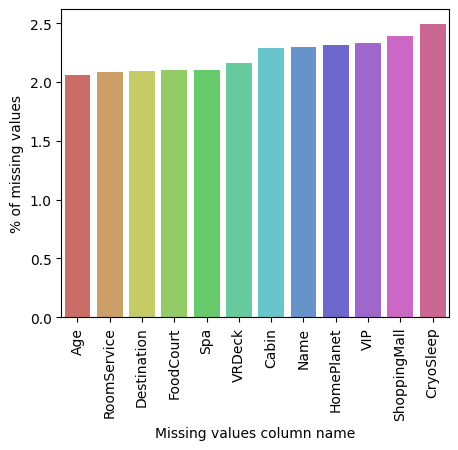

In [10]:
show_missing(percent_nan)

##### Feature engineering - missing values

In [11]:
# PassengerId -> split into gggg and pp
df_train[['Passenger_group', 'Passenger_id']] = df_train['PassengerId'].str.split('_', expand=True).astype(int)
df_train = df_train.drop(['PassengerId', 'Name'], axis=1)

In [12]:
# If the same gggg -> if null for some pp -> same cabin, cryosleep and home planet
common_features_cols = ['HomePlanet', 'Cabin', 'CryoSleep']
df_train = df_train.convert_dtypes()

for col in common_features_cols:
    df_train[col] = df_train.groupby('Passenger_group', group_keys=False)[col].apply(lambda x: x.ffill().bfill())

In [13]:
amenities_cols = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']

In [14]:
# If all of the passengers amenities are 0.0, probably passenger is elected to be put into suspended animation for the duration of the voyage
df_train.loc[df_train[amenities_cols].sum(axis=1) == 0, 'CryoSleep'] = True
df_train.loc[df_train[amenities_cols].sum(axis=1) != 0, 'CryoSleep'] = False

In [15]:
# If the passenger is NOT elected to be put into suspended animation for the duration of the voyage, amenities should be [???]
df_train.loc[df_train['CryoSleep'] == False, amenities_cols] = df_train.loc[df_train['CryoSleep'] == False, amenities_cols].fillna(0)

In [16]:
# If the passenger is elected to be put into suspended animation for the duration of the voyage, amenities should be 0.0
amenities_cols = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
df_train.loc[df_train['CryoSleep'] == True, amenities_cols] = df_train.loc[df_train['CryoSleep'] == True, amenities_cols].fillna(0)

In [17]:
df_train_nums = df_train.select_dtypes(include='Int64')
df_train_nums.corrwith(df_train['Transported']).sort_values()

RoomService       -0.241124
Spa               -0.218545
VRDeck            -0.204874
Age               -0.075026
ShoppingMall       0.009391
Passenger_group    0.021491
FoodCourt          0.045583
Passenger_id       0.066390
dtype: float64

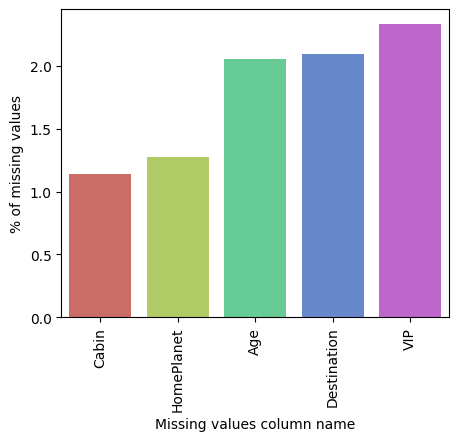

In [18]:
percent_nan = percent_missing(df_train)
show_missing(percent_nan)

###### VIP column - NA value

<Axes: xlabel='VIP', ylabel='count'>

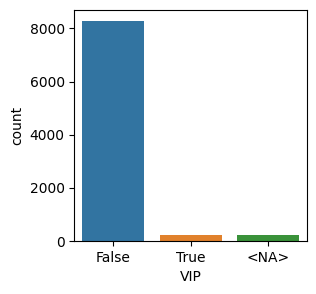

In [19]:
plt.figure(figsize=(3,3))
bool_with_na = df_train['VIP'].astype(str).fillna("Unknown")
sns.countplot(data=df_train, x=bool_with_na, hue=bool_with_na)

In [20]:
vip_most_val = df_train['VIP'].value_counts().sort_values().index[-1]
df_train['VIP'] = df_train['VIP'].fillna(vip_most_val)

###### Destination column - NA value

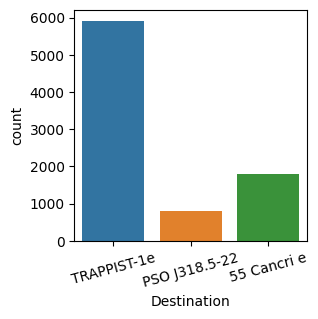

In [21]:
plt.figure(figsize=(3,3))
sns.countplot(data=df_train, x='Destination', hue='Destination')
plt.xticks(rotation=15)
plt.show()

In [22]:
dest_most_val = df_train['Destination'].value_counts().sort_values().index[-1]
df_train['Destination'] = df_train['Destination'].fillna(dest_most_val)

###### HomePlanet column - NA value

<Axes: xlabel='HomePlanet', ylabel='count'>

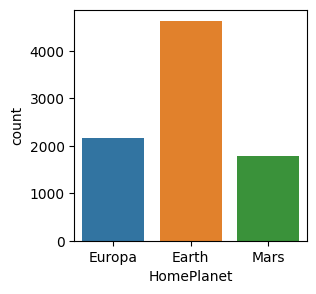

In [23]:
plt.figure(figsize=(3,3))
sns.countplot(data=df_train, x='HomePlanet', hue='HomePlanet')

In [24]:
hp_most_val = df_train['HomePlanet'].value_counts().sort_values().index[-1]
df_train['HomePlanet'] = df_train['HomePlanet'].fillna(hp_most_val)

###### Age column - NA value

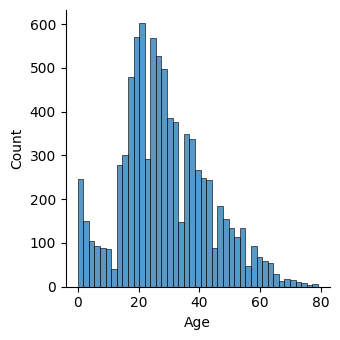

In [25]:
sns.displot(data=df_train, x='Age', height=3.5)

In [26]:
df_train['Age'] = df_train['Age'].fillna(int(df_train['Age'].mean()))

###### Cabin - NA value

In [27]:
# Unique values
len(df_train['Cabin'].unique())

6561

In [28]:
# Cabin -> split into deck, num and side
df_train[['Cabin_deck', 'Cabin_num', 'Cabin_side']] = df_train['Cabin'].str.split('/', expand=True)

In [29]:
df_train['Cabin_deck'].value_counts()

Cabin_deck
F    2808
G    2589
E     886
B     796
C     761
D     487
A     262
T       5
Name: count, dtype: Int64

In [30]:
df_train['Cabin_deck'].astype('category').cat.codes.corr(df_train['Transported'])

np.float64(-0.1078453089529459)

In [31]:
df_train['Cabin_num'].value_counts()

Cabin_num
82      28
86      22
19      22
97      21
176     21
        ..
1866     1
1867     1
1868     1
1870     1
1884     1
Name: count, Length: 1817, dtype: Int64

In [32]:
df_train['Cabin_num'].astype('category').cat.codes.corr(df_train['Transported'])

np.float64(0.02204992622585008)

In [33]:
df_train['Cabin_side'].value_counts()

Cabin_side
S    4343
P    4251
Name: count, dtype: Int64

In [34]:
df_train['Cabin_side'].value_counts().values

<IntegerArray>
[4343, 4251]
Length: 2, dtype: Int64

In [35]:
df_train['Cabin_side'].astype('category').cat.codes.corr(df_train['Transported'])

np.float64(0.10206041096663274)

In [36]:
# Correlation with Cabin_num is not so important, so it can be deleted
df_train = df_train.drop(['Cabin', 'Cabin_num'], axis=1)

In [37]:
# Filling cabin deck
value_counts = df_train['Cabin_deck'].value_counts()
idx_cabin_deck = value_counts.index
val_cabin_deck = value_counts.values

probabilities = val_cabin_deck / val_cabin_deck.sum()

df_train.loc[df_train['Cabin_deck'].isna(), 'Cabin_deck'] = np.random.choice(idx_cabin_deck, size=df_train['Cabin_deck'].isna().sum(), p=probabilities)

In [38]:
# Filling cabin side
value_counts = df_train['Cabin_side'].value_counts()
idx_cabin_side = value_counts.index
val_cabin_side = value_counts.values

probabilities = val_cabin_side / val_cabin_side.sum()

df_train.loc[df_train['Cabin_side'].isna(), 'Cabin_side'] = np.random.choice(idx_cabin_side, size=df_train['Cabin_side'].isna().sum(), p=probabilities)

###### Final check NA value

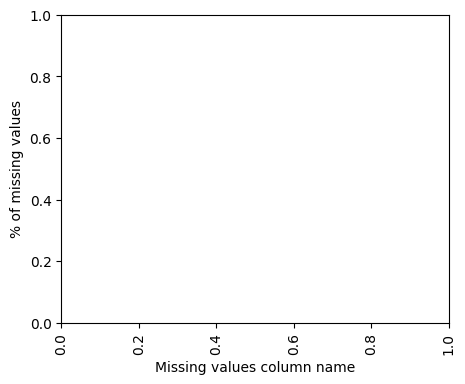

In [39]:
percent_nan = percent_missing(df_train)
show_missing(percent_nan)

##### Conclusions
Split PassengerId -> Passenger_group, Passenger_id columns\
Split Cabin -> Cabin_deck, Cabin_num, Cabin_side columns\
Drop PassengerId, Cabin and Cabin_num\
Drop Passenger_group and Passenger_id after feature engineering

#### Statistical analysis

In [40]:
df_train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Passenger_group,Passenger_id
count,8693.0,8693.0,8693.0,8693.0,8693.0,8693.0,8693.0,8693.0
mean,28.810882,220.009318,448.434027,169.5723,304.588865,298.26182,4633.389624,1.517773
std,14.339536,660.51905,1595.790627,598.007164,1125.562559,1134.126417,2671.028856,1.054241
min,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
25%,20.0,0.0,0.0,0.0,0.0,0.0,2319.0,1.0
50%,27.0,0.0,0.0,0.0,0.0,0.0,4630.0,1.0
75%,37.0,41.0,61.0,22.0,53.0,40.0,6883.0,2.0
max,79.0,14327.0,29813.0,23492.0,22408.0,24133.0,9280.0,8.0


In [41]:
df_train.describe(include='string')

,HomePlanet,Destination,Cabin_deck,Cabin_side
count,8693,8693,8693,8693
unique,3,3,8,2
top,Earth,TRAPPIST-1e,F,S
freq,4745,6097,2839,4400


In [42]:
df_train.describe(include='boolean')

,CryoSleep,VIP,Transported
count,8693,8693,8693
unique,2,2,2
top,False,False,True
freq,5040,8494,4378


In [43]:
df_train_dummies = pd.get_dummies(df_train, drop_first=True)
df_train_dummies.corr()['Transported'].sort_values()

RoomService                 -0.241124
Spa                         -0.218545
VRDeck                      -0.204874
Destination_TRAPPIST-1e     -0.096319
Cabin_deck_E                -0.094862
Cabin_deck_F                -0.088695
Age                         -0.074245
VIP                         -0.037261
Cabin_deck_D                -0.033637
Cabin_deck_T                -0.014568
Destination_PSO J318.5-22    0.000092
ShoppingMall                 0.009391
Cabin_deck_G                 0.014052
HomePlanet_Mars              0.019941
Passenger_group              0.021491
FoodCourt                    0.045583
Passenger_id                 0.066390
Cabin_side_S                 0.100807
Cabin_deck_C                 0.106456
Cabin_deck_B                 0.144750
HomePlanet_Europa            0.179756
CryoSleep                    0.481628
Transported                  1.000000
Name: Transported, dtype: float64

<Axes: >

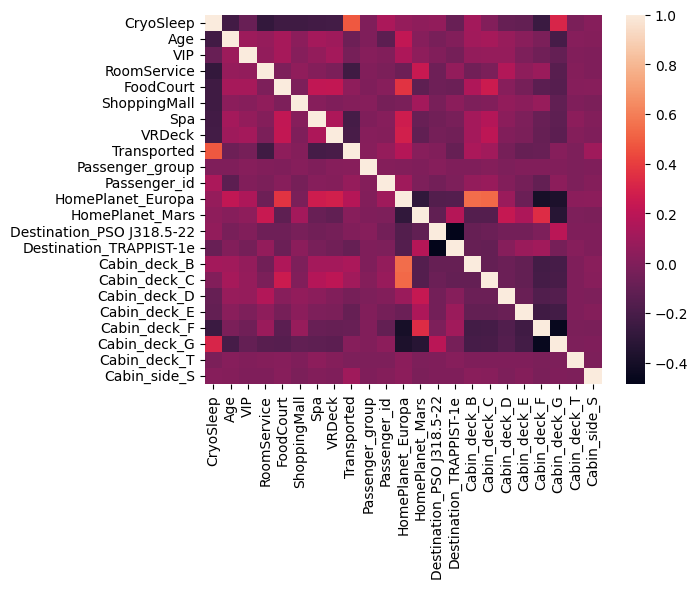

In [44]:
sns.heatmap(df_train_dummies.corr())

In [45]:
df_train = df_train_dummies

##### Conclusions
TODO

#### Outliers and visualisations

In [46]:
numeric_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

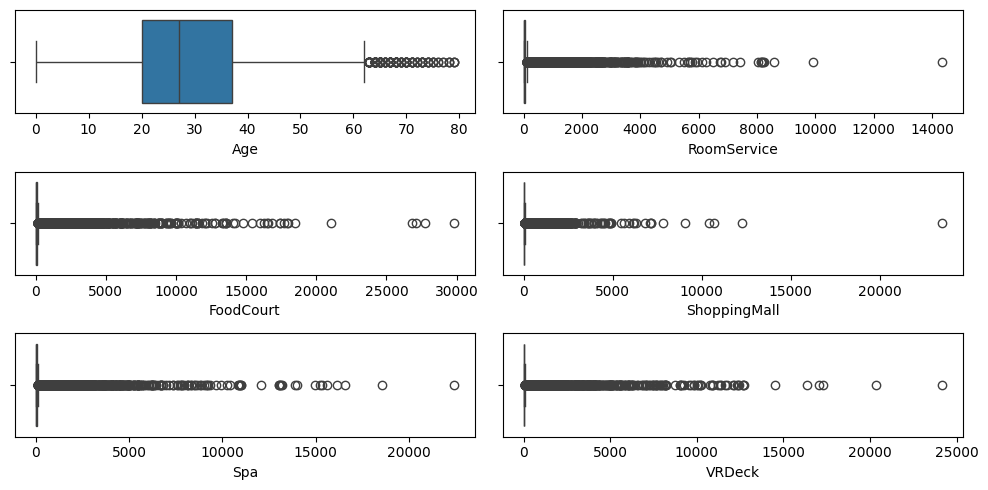

In [47]:
fig, axes = plt.subplots(3,2)
fig.set_size_inches(10,5)
sns.boxplot(data=df_train, x=numeric_cols[0], ax=axes[0][0])
sns.boxplot(data=df_train, x=numeric_cols[1], ax=axes[0][1])
sns.boxplot(data=df_train, x=numeric_cols[2], ax=axes[1][0])
sns.boxplot(data=df_train, x=numeric_cols[3], ax=axes[1][1])
sns.boxplot(data=df_train, x=numeric_cols[4], ax=axes[2][0])
sns.boxplot(data=df_train, x=numeric_cols[5], ax=axes[2][1])
plt.tight_layout()

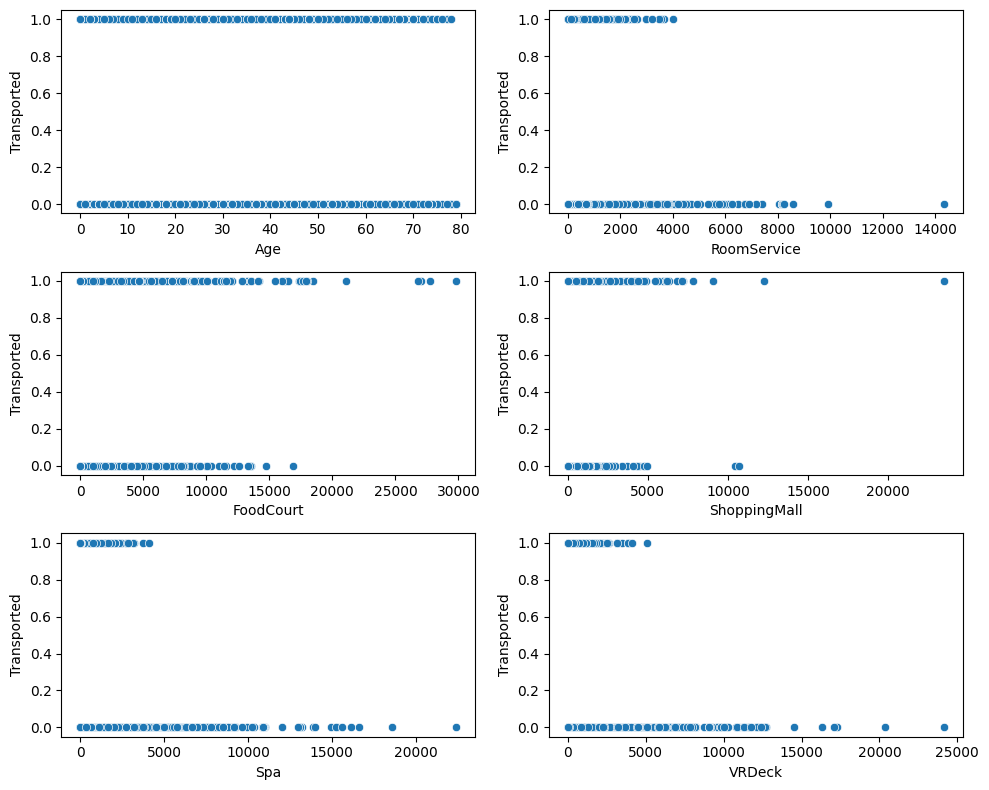

In [48]:
fig, axes = plt.subplots(3,2)
fig.set_size_inches(10,8)
sns.scatterplot(data=df_train, x=numeric_cols[0], y='Transported', ax=axes[0][0])
sns.scatterplot(data=df_train, x=numeric_cols[1], y='Transported', ax=axes[0][1])
sns.scatterplot(data=df_train, x=numeric_cols[2], y='Transported', ax=axes[1][0])
sns.scatterplot(data=df_train, x=numeric_cols[3], y='Transported', ax=axes[1][1])
sns.scatterplot(data=df_train, x=numeric_cols[4], y='Transported', ax=axes[2][0])
sns.scatterplot(data=df_train, x=numeric_cols[5], y='Transported', ax=axes[2][1])
plt.tight_layout()

##### Dealing with outliers

In [49]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] > upper_bound, df[column].median(), df[column])  # Zamiana wartości na medianę
    return df

for col in numeric_cols:
    df_train = remove_outliers(df_train, col)

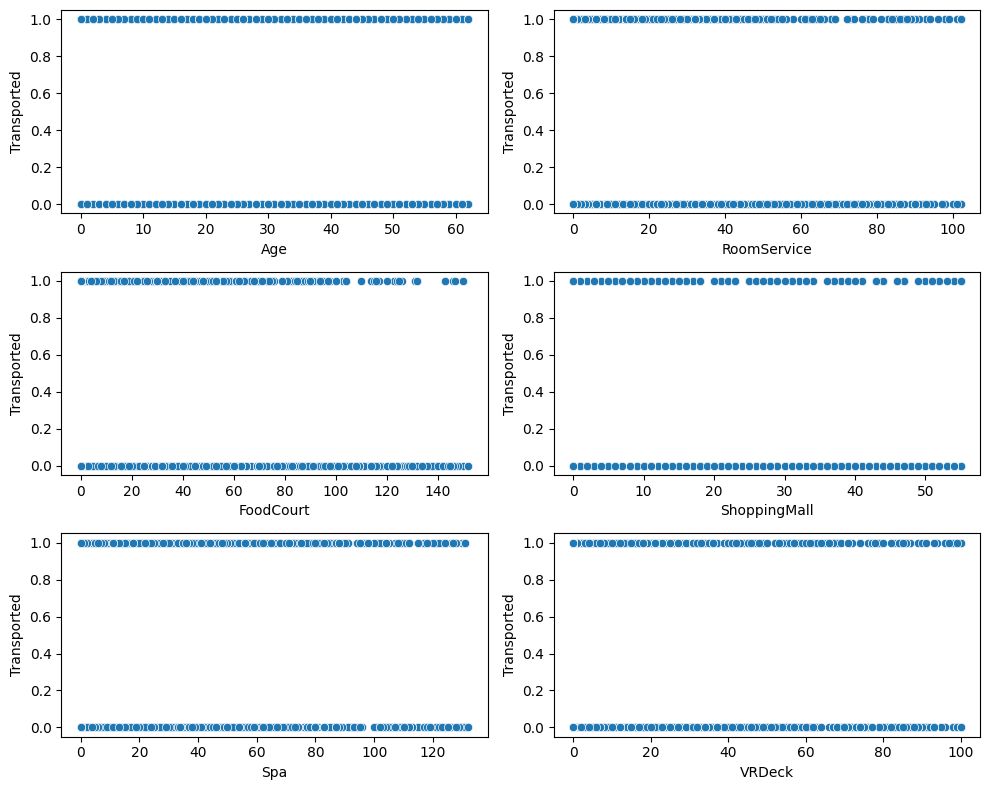

In [50]:
fig, axes = plt.subplots(3,2)
fig.set_size_inches(10,8)
sns.scatterplot(data=df_train, x=numeric_cols[0], y='Transported', ax=axes[0][0])
sns.scatterplot(data=df_train, x=numeric_cols[1], y='Transported', ax=axes[0][1])
sns.scatterplot(data=df_train, x=numeric_cols[2], y='Transported', ax=axes[1][0])
sns.scatterplot(data=df_train, x=numeric_cols[3], y='Transported', ax=axes[1][1])
sns.scatterplot(data=df_train, x=numeric_cols[4], y='Transported', ax=axes[2][0])
sns.scatterplot(data=df_train, x=numeric_cols[5], y='Transported', ax=axes[2][1])
plt.tight_layout()

### Data preparation

In [51]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [52]:
evaluation_dict = {}

### Train | Test Split

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Evaluation

#### Overfitting check

### Model

### Evaluation

#### Overfitting check

### Model

### Evaluation

#### Overfitting check

### Model

### Evaluation

#### Overfitting check

##### Conclusions
TODO

### Final Conclusions
TODO